Usual set up:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/HEDSpython

Mounted at /content/drive
/content/drive/MyDrive/HEDSpython


#**Data Science Algorithms I: PCA and k-means clustering**

Let's import our usual libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

And load our csv

In [ ]:
csvFilePath = 'files/WVS_Cross-National_Wave_7_csv_v4_0.csv'
rawData = pd.read_csv(csvFilePath)

<ipython-input-4-f1a1bfccab7b>:2: DtypeWarning: Columns (519,520,521,522) have mixed types. Specify dtype option on import or set low_memory=False.
  rawData = pd.read_csv(csvFilePath)


Let's check what the initial shape of our dataframe is.

In [ ]:
print('Initial shape of the dataset is', rawData.shape)

Initial shape of the dataset is (63367, 552)


Wow! 552 columns. We want to select only the features which are relevant to us. In this case, the first 290 questions.

In [ ]:
Nquestions = 290
featuresToKeep = []
for q in range(1,Nquestions+1):
    featuresToKeep.append('Q'+str(q))

WVS = rawData.loc[:, featuresToKeep]

print('Final shape of the dataset is', WVS.shape)

Final shape of the dataset is (63367, 290)


We also want to retain some general features for later.

In [ ]:
generalFeatures = ['B_COUNTRY_ALPHA', 'O1_LONGITUDE', 'O2_LATITUDE']
WVSgeneral = rawData.loc[:, generalFeatures]

We can now delete the del `rawData` from the local memory.

In [ ]:
del rawData

Let's plot a histogram of the observations by country.

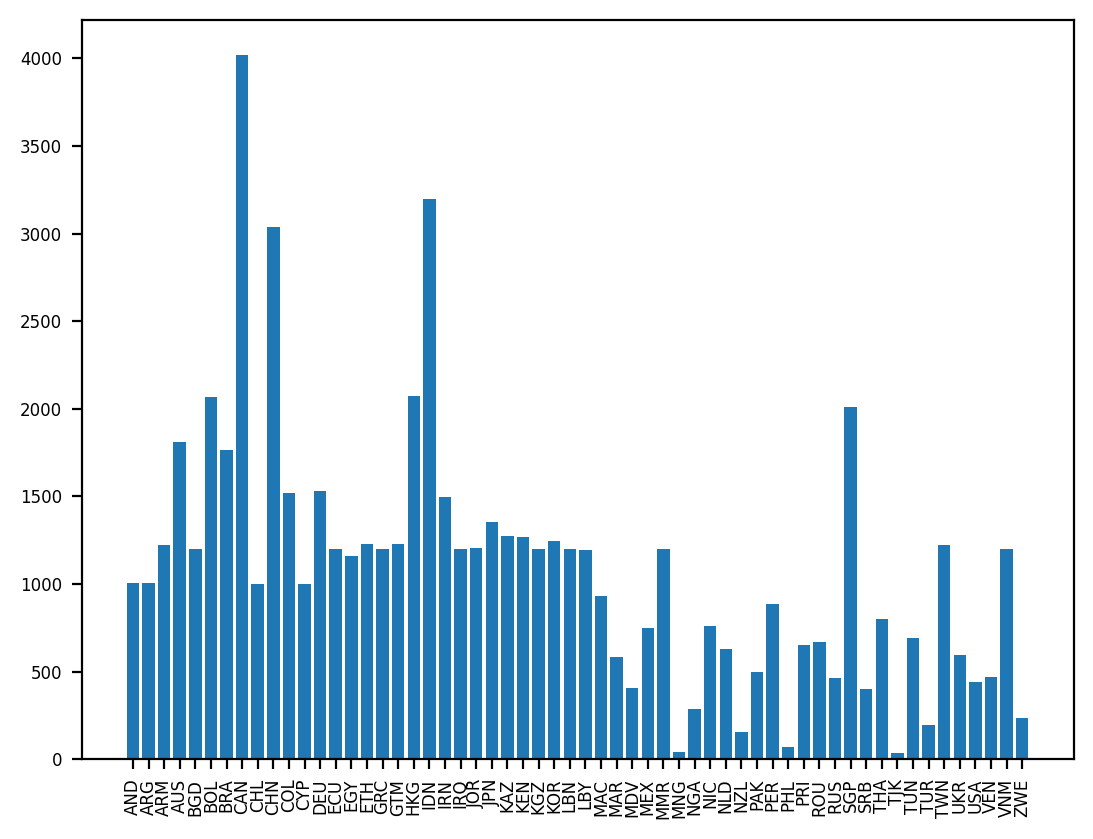

In [ ]:
countries, numSurveysInCountry = np.unique(WVSgeneral.B_COUNTRY_ALPHA,return_counts=True)
dummy = range(len(countries))

plt.figure(dpi=200)
plt.rcParams.update({'font.size': 6})
plt.bar(dummy,numSurveysInCountry, align='center')
plt.xticks(dummy, countries)
plt.xticks(rotation = 90)
plt.show()

Now let's clean the dataset.

For each question we cna check which is the most common value and how many null values there are.

In [ ]:
nanQuestions = []
for q in range(1,Nquestions+1):
    labels, counts = np.unique(WVS['Q'+str(q)],return_counts=True)
    print('Q'+str(q)+' - ', 'Most common: ' , labels[counts.argmax()], ',',
            '#Empty: ', WVS['Q'+str(q)].isna().sum())
    if np.isnan(labels[counts.argmax()]):
        nanQuestions.append(q)

Q1 -  Most common:  1.0 , #Empty:  77
Q2 -  Most common:  2.0 , #Empty:  197
Q3 -  Most common:  2.0 , #Empty:  335
Q4 -  Most common:  3.0 , #Empty:  746
Q5 -  Most common:  1.0 , #Empty:  621
Q6 -  Most common:  1.0 , #Empty:  517
Q7 -  Most common:  1.0 , #Empty:  232
Q8 -  Most common:  2.0 , #Empty:  809
Q9 -  Most common:  1.0 , #Empty:  513
Q10 -  Most common:  1.0 , #Empty:  391
Q11 -  Most common:  2.0 , #Empty:  880
Q12 -  Most common:  1.0 , #Empty:  445
Q13 -  Most common:  2.0 , #Empty:  866
Q14 -  Most common:  2.0 , #Empty:  864
Q15 -  Most common:  2.0 , #Empty:  837
Q16 -  Most common:  2.0 , #Empty:  803
Q17 -  Most common:  2.0 , #Empty:  874
Q18 -  Most common:  1.0 , #Empty:  573
Q19 -  Most common:  2.0 , #Empty:  735
Q20 -  Most common:  2.0 , #Empty:  877
Q21 -  Most common:  2.0 , #Empty:  786
Q22 -  Most common:  2.0 , #Empty:  2322
Q23 -  Most common:  2.0 , #Empty:  759
Q24 -  Most common:  1.0 , #Empty:  632
Q25 -  Most common:  2.0 , #Empty:  1916
Q26 -  M

We can use the excel file and the questionnaire pdf in the files folder to check *weird* values.

We can then delete questions for which most common values are null or weird.

In [ ]:
mostCommonIsNaN = ['Q86','Q92', 'Q223', 'Q230', 'Q240', 'Q266', 'Q267', 'Q268', 'Q276', 'Q280', 'Q282', 'Q290']
mostCommonIsWeird = ['Q272']
questionsToRemove = mostCommonIsNaN + mostCommonIsWeird
WVS = WVS.drop(questionsToRemove, axis=1)

And then substitute `NaN` values with the most frequent answer for each question.

In [ ]:
for name, values in WVS.items():
    labels, counts = np.unique(values,return_counts=True)
    values[values.isna()] = labels[counts.argmax()]

We use the `sklearn` library to run our analysis. `sklearn` (or scikit-learn) is a powerful library for machine learning.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

##**Principal Component Analysis**

Principal component analysis (PCA) is a dimensionality reduction technique that allows us to reduce a large set fo variables into a smaller one that still contains most of the information of the large dataset.

As a first step we need to standardize all variables in the dataset to make sure that each of the variables contribute equally in the analysis.

Standardizing a variable means to reduce it to a unit scale (that is to mean = 0 and variance = 1).

In [ ]:
standWVS = StandardScaler().fit_transform(WVS)

We use the `PCA()` and `.fit_transform()` functions to preform the reduction into a lower dimensional space, the argument `n_components` indicates how many components the variables should be reduced to.

Let's reduce the variables to two principal components, to start with.

In [ ]:
pcaObj = PCA(n_components=2)
prComp = pcaObj.fit_transform(standWVS)

array([19.11747254, 14.48499324])

We the plot one component over the other to see how well of a job our components do in explaining the data.

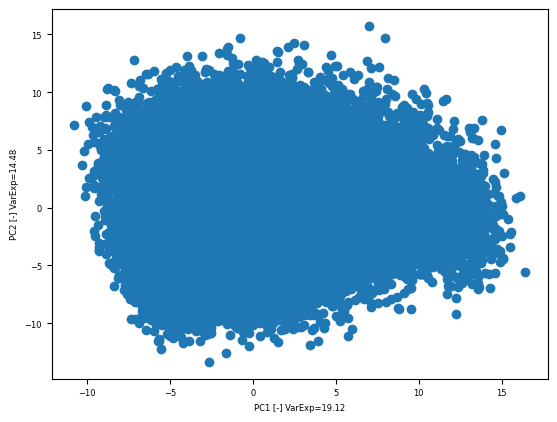

In [ ]:
plt.figure(dpi=100)
plt.scatter(prComp[:,0], prComp[:,1])
plt.xlabel('PC1 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[0])
plt.ylabel('PC2 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[1])
plt.show()

The presence of an indiscernible round cluster tells us that our components do not detect clear-cut discernable features of our dataset (i.e., they do not summarize well information in our data).

This is confirmed by the fact that PC1 and PC2 together only explain a small amount of variance in the dataset.

In [ ]:
pcaObj.explained_variance_ratio_.cumsum()

array([0.06901506, 0.12130663])

Only 12%! Let's try with three components then.

In [ ]:
pcaObj = PCA(n_components=3)
prComp = pcaObj.fit_transform(standWVS)

In [ ]:
pcaObj.explained_variance_ratio_.cumsum()

array([0.06901506, 0.12130663, 0.15574443])

Three PCs explain only 16% of the variance, that's not a lot either. We can still plot this to see what it looks like.

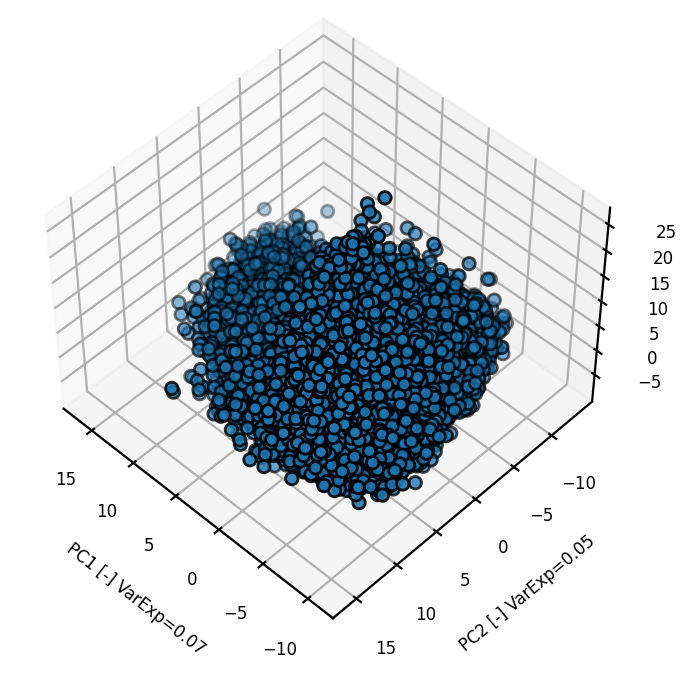

In [ ]:
fig = plt.figure(1, figsize=(4, 3), dpi=200)
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])
plt.cla()
ax.scatter(prComp[:,0], prComp[:,1], prComp[:,2], edgecolor="k")
ax.set_xlabel('PC1 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[0])
ax.set_ylabel('PC2 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[1])
ax.set_zlabel('PC3 [-] VarExp=%1.2f' %pcaObj.explained_variance_ratio_[2])
plt.show()

Indeed, this is also an indiscernible cluster.

The rule of thumb is that PCs do a good job when they explain at least 70% of the variance. Let's see how many PCs we need to hit the target. Let's calculate the percentage of variance explained by PCs from 2 up to 100.

In [ ]:
totVarianceExplained = []
NprincComp = range(2,100)
for comp in NprincComp:
    pcaObjDummy = PCA(n_components=comp)
    pcDummy = pcaObjDummy.fit_transform(standWVS)
    totVarianceExplained.append(pcaObjDummy.explained_variance_ratio_)

And now let's check how 100 PCs do.

In [ ]:
totVarianceExplained[-1]

array([19.11747254, 14.48499324,  9.53942117,  6.99186996,  4.74885774,
        4.60107254,  4.28783948,  3.74097801,  3.5712577 ,  3.26727824,
        2.97322478,  2.79258362])

Not great...

We can plot our results to see how suitable PCA is for our data. This is called sensitivity analysis. We use it to identify the main factors that influence PCA results and to determine the reliability of our conclusions.

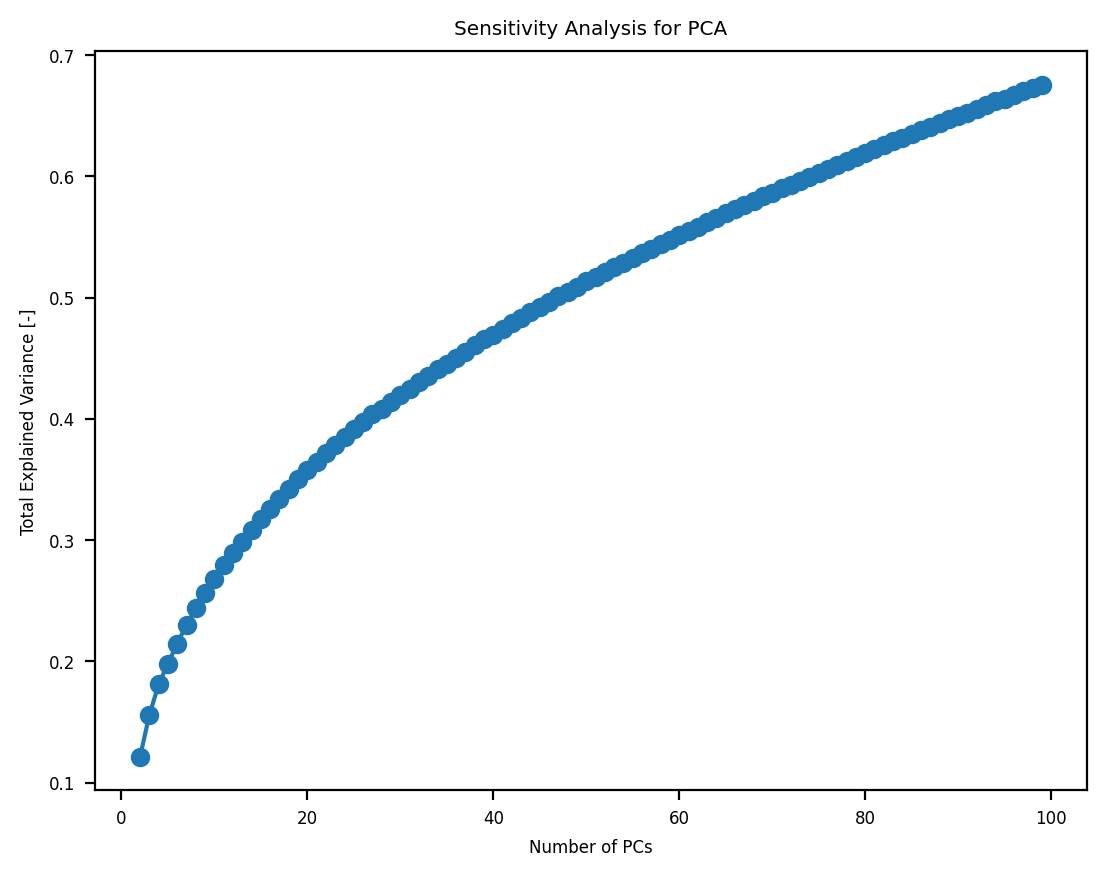

In [ ]:
plt.figure(dpi=200)
plt.plot(NprincComp, totVarianceExplained, marker='o')
plt.title('Sensitivity Analysis for PCA')
plt.xlabel('Number of PCs')
plt.ylabel('Total Explained Variance [-]')
plt.show()

As you can see, as the number of PCs goes up the variance explained increases following a semi-linear trend, indicating that PCA is not very useful for our data 😢

## **K-means clustering**

K-means clustering is a data segmentation method aimed at grouping n observation into k clusters assigning each observation to the cluster with the nearest mean.

Similarly to PCA, perform k-means clustering in `sklearn` we use a combination of the fucntions `KMeans()` and `fit()`.

We can combine k-means clustering with PCA to increase the segmentation of our results. Even if PCA was not successful in itself, it is still useful to improve data segmentation as it reduces the number of features and the noise in the data.

In [ ]:
inertias = []
Nclusters = range(1,50)
for i in Nclusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(prComp)
    inertias.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

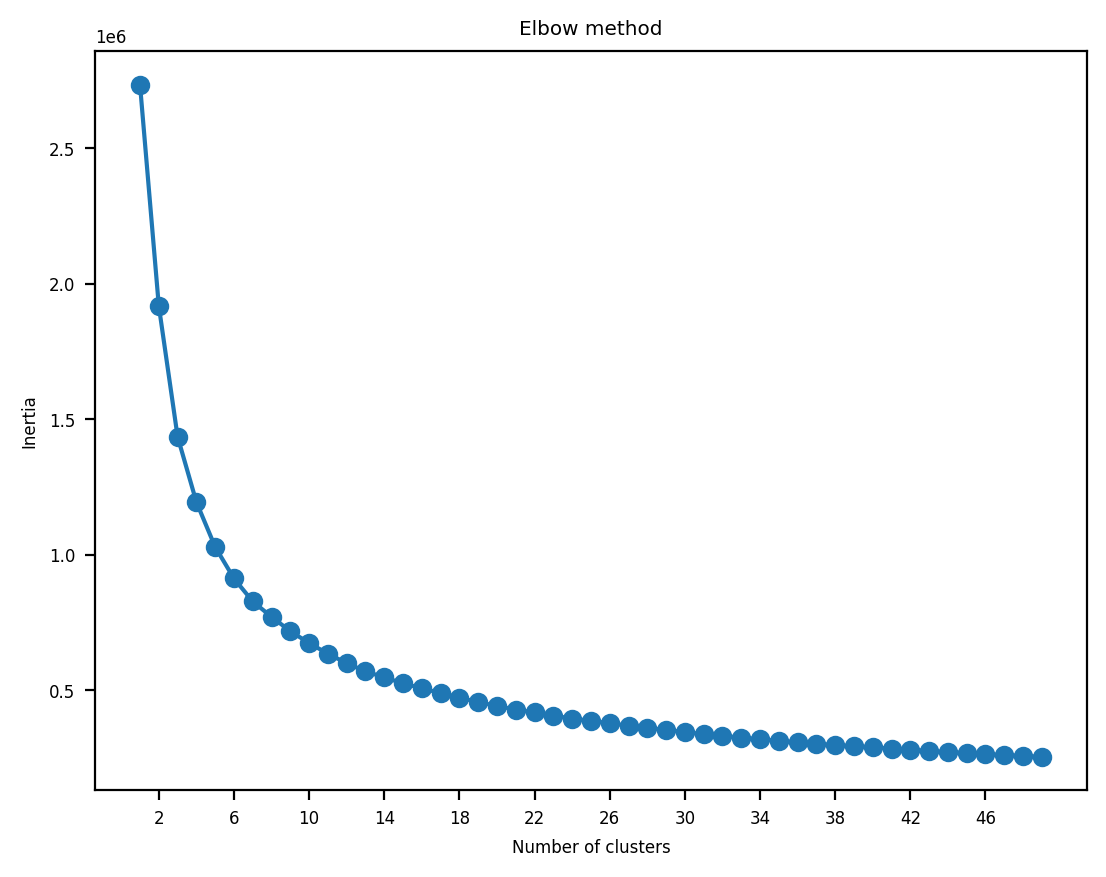

In [ ]:
plt.figure(dpi=200)
plt.plot(Nclusters, inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.xticks(Nclusters[1::4])
plt.ylabel('Inertia')
plt.show()

We use *elbow method* to identify how many clusters we should keep, that is, we look for the *elbow* or the place where the inertia begins to slow. In this case, 6 seems the right number of clusters to use.

Note: the same method is valid for PCA - we would look at the upside *elbow*. Our sensitivity analysis just did not show an elbow, sadly.

We can now combine the two methods and take a look at our clusters.

In [ ]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(prComp)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6)

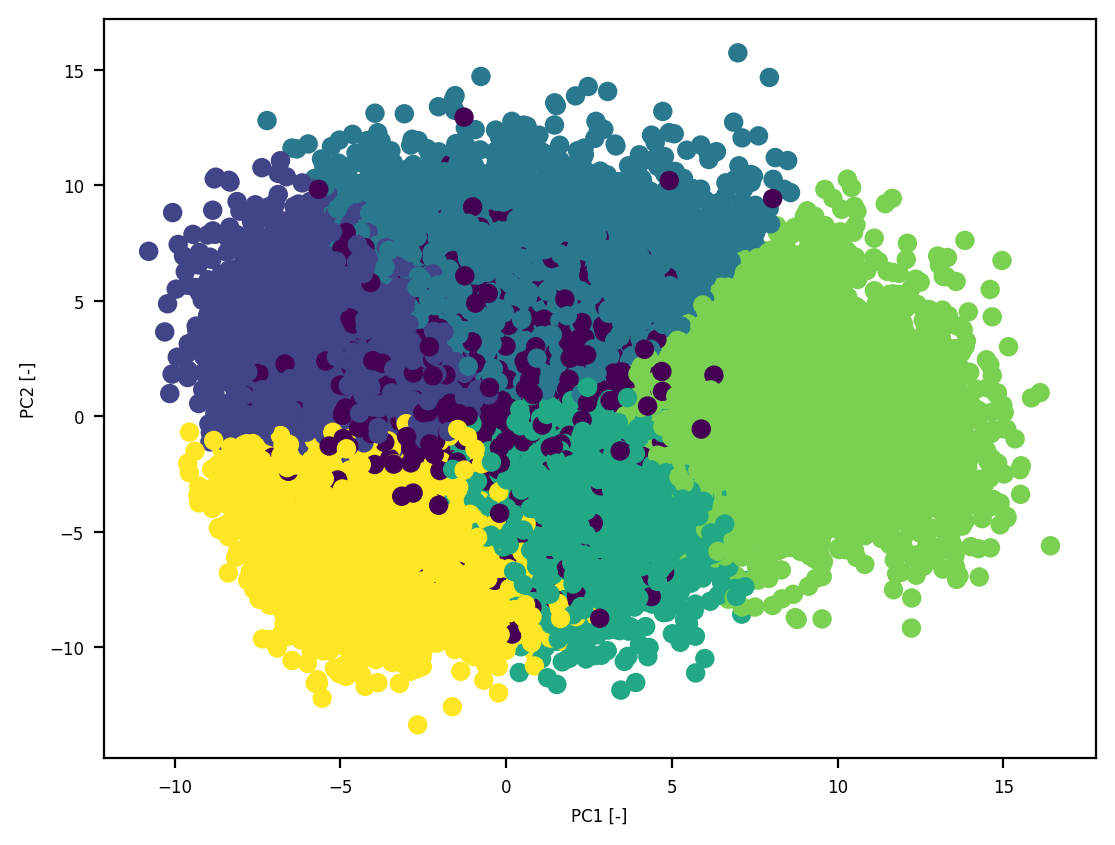

In [ ]:
plt.figure(dpi=200)
plt.scatter(prComp[:,0], prComp[:,1], c= kmeans.labels_)
plt.xlabel('PC1 [-]')
plt.ylabel('PC2 [-]')
plt.show()